In [228]:
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

#!pip install shap
import shap
from tqdm import tqdm

In [229]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average = 'micro')
    recall = recall_score(y_test, pred, average = 'micro')
    f1 = f1_score(y_test, pred ,average = 'micro')
    
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}, F1: {3:.4f}'
          .format(accuracy, precision, recall, f1))

### 1. Dataset Load

In [230]:
import pandas as pd
dataset = pd.read_csv("feature_permission.csv")
X_features = dataset.loc[:,dataset.columns != 'label']

y_label = dataset['label']

dataset.loc[:,dataset.columns != 'label']
print('피처 데이터 shape:{0}'.format(X_features.shape))

피처 데이터 shape:(22985, 206)


### 2. Dataset Split(Train, Eval, Test)

In [231]:
## without validation date
# X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
#                                                     test_size=0.3, random_state=31)

# with validation date
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.4, random_state=0)
X_eval, X_test, y_eval, y_test = train_test_split(X_test, y_test, 
                                                  test_size=0.5, random_state=0)

train_cnt = y_train.count() # train 데이터 수
eval_cnt = y_eval.count() # validation 데이터 수
test_cnt = y_test.count() # test 데이터 수


print('학습 세트 Shape:{0}, 검증 세트 Shape:{1} 테스트 세트 Shape:{2}'.format(X_train.shape, X_eval.shape, X_test.shape))


print('학습 세트 레이블 값 분포 비율')
# print(y_train.value_counts()/train_cnt)
print(y_train.value_counts())

print('검증 세트 레이블 값 분포 비율')
# print(y_eval.value_counts()/eval_cnt)
print(y_eval.value_counts())

print('\n테스트 세트 레이블 값 분포 비율')
# print(y_test.value_counts()/test_cnt)
print(y_test.value_counts())

학습 세트 Shape:(13791, 206), 검증 세트 Shape:(4597, 206) 테스트 세트 Shape:(4597, 206)
학습 세트 레이블 값 분포 비율
1.0    7509
0.0    6282
Name: label, dtype: int64
검증 세트 레이블 값 분포 비율
1.0    2512
0.0    2085
Name: label, dtype: int64

테스트 세트 레이블 값 분포 비율
1.0    2495
0.0    2102
Name: label, dtype: int64


### 3. Train Model Load

In [232]:
# # # model 파일로 저장, 저장형식은 json, 하지만 json은 txt로 저장했을 때 보다 용량이 2배크다...
# xgrid_xgb_clf.save_model('grid_xgb_clf.json')

# 불러올 때 어떤 모델이냐에 따라 다르게 해준다. train으로 학습했기에 불러올 때 Booster()를 사용
xgb_clf = XGBClassifier()
xgb_clf.load_model('grid_xgb_clf.json')


w_preds = xgb_clf.predict(X_test) # 분류 결과(label)
print(w_preds)

w_pred_proba = xgb_clf.predict_proba(X_test)[:,1] # 분류 결과(확률)
print(w_pred_proba)


[1 1 1 ... 0 1 1]
[0.9932886 0.9992085 0.9989724 ... 0.002115  0.9974832 0.9999074]


In [233]:
get_clf_eval(y_test, w_preds, w_pred_proba)

Confusion Matrix
[[1984  118]
 [ 107 2388]]
Accuracy: 0.9511, Precision: 0.9511, Recall: 0.9511, F1: 0.9511


# XAI_SHAP


1. 학습 모델 load 후 해당 모델을 Explainer에 파라미터로 전달
2. 학습 시킬 때 사용했던 Train 데이터를 explainer의 인자하여 학습

In [234]:
explainer = shap.TreeExplainer(xgb_clf)

In [235]:
shap_values = explainer(X_train)
shap_values.shape

(13791, 206)

전체 데이터에 대한 각 feature의 shap_values 평균

In [236]:
sum_sv = np.array([0 for i in range(len(shap_values[0]))]).astype(np.float32)

In [237]:
for each_sample in tqdm(shap_values.values):
    sum_sv += each_sample
#     for i, each_feature in enumerate(each_sample):
#         sum_sv[i]+=each_feature

100%|████████████████████████████████████████████████████████████████████████| 13791/13791 [00:00<00:00, 427451.90it/s]


In [238]:
# 열 단위로 평균 반환
# 각  feature에 대한 정보
print(np.mean(shap_values.values, axis = 0))

# 행 단위로 평균 반환
# 각 샘플에 대한 정보
print(np.mean(shap_values.values, axis = 1))

[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -1.8026996e-02  3.8682375e-02  5.6486302e-03  0.0000000e+00
  5.4116167e-02  0.0000000e+00 -1.5025160e-02 -6.6180230e-04
  0.0000000e+00  0.0000000e+00  0.0000000e+00  2.3023798e-03
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -5.3246134e-05 -2.0001552e-03  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  1.7258910e-05  2.8701343e-03  0.0000000e+00
  0.0000000e+00 -2.2684054e-02  0.0000000e+00  7.5343591e-03
 -9.9416205e-04  6.89277

In [246]:
# 분류에 있어 가장 큰 영향을 미치는 feature
print("최대 feature:", X_train.columns[np.argmax(sum_sv)],
      " 값:", sum_sv.max())


# 분류에 있어 가장 방해가 되는 feature
print("최소 feature:", X_train.columns[np.argmin(sum_sv)],
      " 값:", sum_sv.min())

# 분류에 있어 가장 큰 영향을 미치는 feature
# print("최대 feature:", X_train.columns[np.argmax(sum_sv)],
#       " 값:", sum_sv.max()/len(X_train))

# 분류에 있어 가장 방해가 되는 feature
# print("최소 feature:", X_train.columns[np.argmin(sum_sv)],
#       " 값:", sum_sv.min()/len(X_train))

print("평균:", sum_sv.mean())

최대 feature: android.permission.SEND_SMS  값: 5381.6924
최소 feature: android.permission.INTERNET  값: -1422.1548
평균: 50.166668


In [241]:
len(X_train)

13791

각 feature에 대한 평균

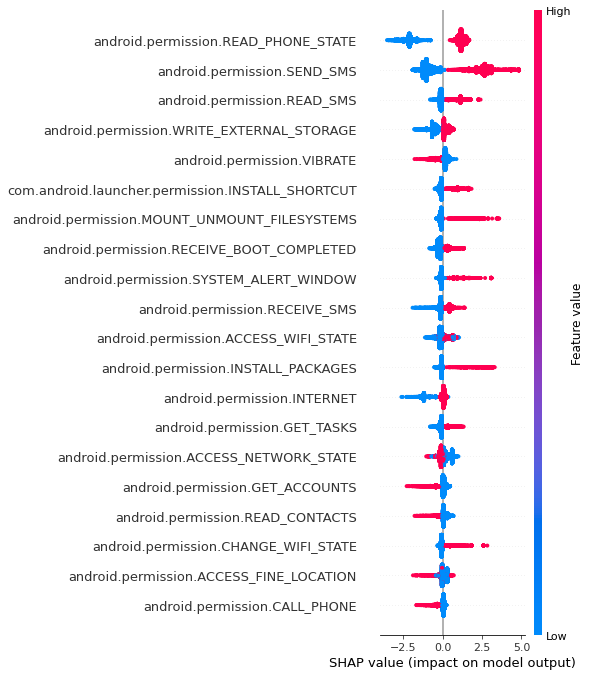

In [22]:
shap.summary_plot(shap_values, X_train)

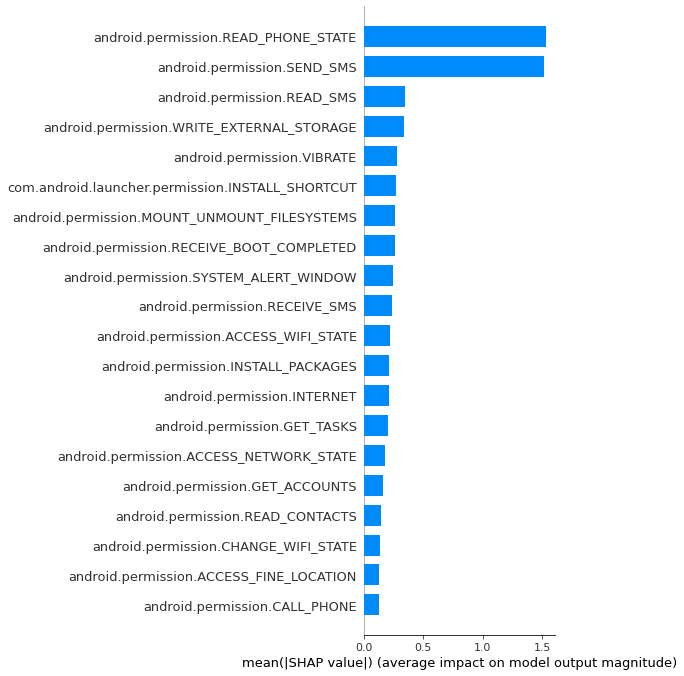

In [30]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

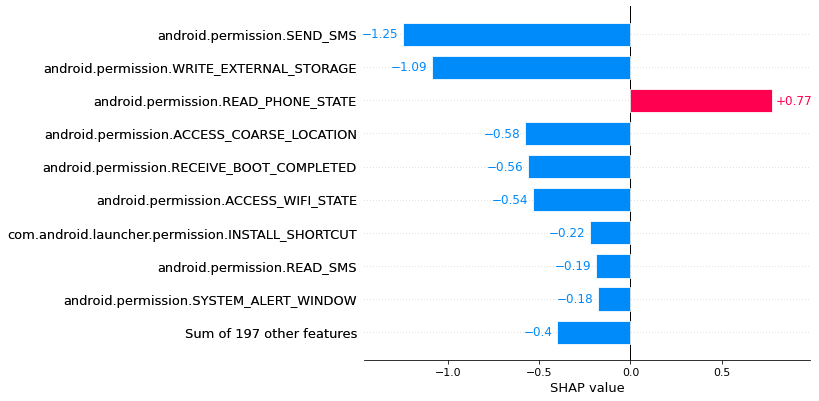

In [24]:
# visualize the first prediction's explanation
shap.plots.bar(shap_values[0])


In [25]:
# # visualize the first prediction's explanation with a force plot
# shap.plots.force(shap_values[0])

In [26]:
# # visualize all the training set predictions
# shap.plots.force(shap_values)

In [27]:
# # create a dependence scatter plot to show the effect of a single feature across the whole dataset
# shap.plots.scatter(shap_values[:,"RM"], color=shap_values)

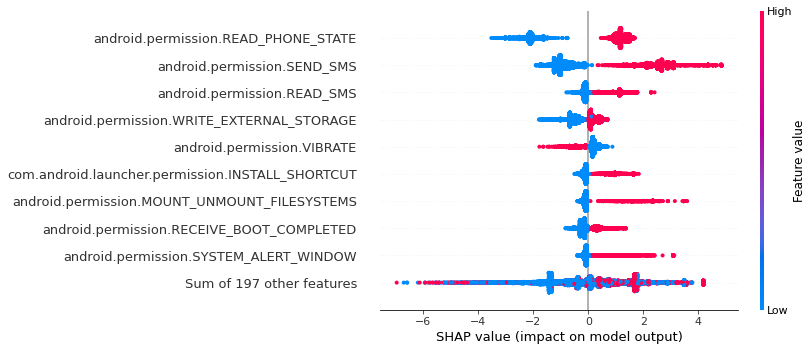

In [28]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

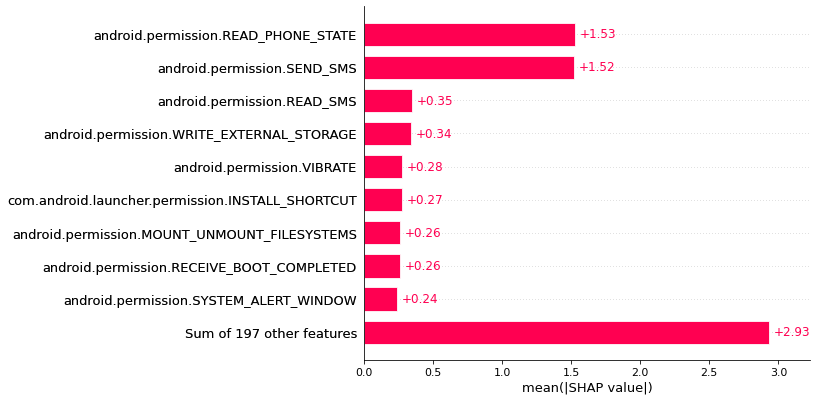

In [29]:
shap.plots.bar(shap_values)